In [1]:
%matplotlib inline

In [2]:
'''
本文件用于将原始的JAFFE图片数据集按照人物区分，再分成七大类：
neutral, happy, sadness, surprise, angry, disgust, fear
'''
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

original_data_dir_path = "../data/raw_data/jaffe"
semantic_rating_data_path = "../data/raw_data/jaffe/jaffe_semantic_rating_data"

rebuild_dir_pre_path = "../data/jaffe"

In [6]:
# 读取图片列表
filenames_list = os.listdir(original_data_dir_path)
filenames_map = {}
person_name_set = set()
for filename in filenames_list.copy():
    if filename.split(".")[-1] != "tiff":
        filenames_list.remove(filename)
    else:
        filenames_map[filename] = ""
        person_name_set.add(filename[:2])
person_name_list = list(person_name_set)
print(len(filenames_list), len(filenames_map), len(person_name_list))
print(person_name_list)

213 213 10
['KA', 'UY', 'KL', 'NM', 'YM', 'TM', 'KR', 'NA', 'KM', 'MK']


In [7]:
# 建立图片构建的路径目录
dirs = [rebuild_dir_pre_path+"/"+p for p in person_name_list]
dirs.insert(0, rebuild_dir_pre_path)
for dir in dirs:
    if not os.path.exists(dir):
        os.mkdir(dir)
    else:
        fl = os.listdir(original_data_dir_path)
        for filename in fl:
            try:
                os.remove(os.path.join(dir, filename))
            except:
                pass

In [8]:
def read_semantic_rating_data(file_path, with_FER = True):
    '''
    读取语义评级数据
    '''
    with open(file_path, "r") as file:
        lines = file.readlines()
    if with_FER:
        return lines[1:220]
    else:
        return lines[222:409]

In [9]:
def get_class_with_semantic_rating_data(lines, filenames_map):
    '''
    根据给出的语义评级数据来决定分类
    '''
    for line in lines:
        if line[0] == "#":
            continue
        if with_FER:
            IND, HAP, SAD, SUR, ANG, DIS, FEA, PIC = line.split(" ")
        else:
            IND, HAP, SAD, SUR, ANG, DIS, PIC = line.split(" ")
            FEA = -1.0
        if PIC[-1] == "\n":
            PIC=PIC[:-1]
        PIC = PIC.replace("-", ".")
        filename = PIC+"."+IND+".tiff"
        if filename in filenames_map:
            HAP_rate, SAD_rate, SUR_rate, ANG_rate, DIS_rate, FER_rate = float(HAP), float(SAD), float(SUR), float(ANG), float(DIS), float(FEA)
#             print(HAP_rate, SAD_rate, SUR_rate, ANG_rate, DIS_rate, DIS_rate, FER_rate)
            class_should_be_rate = max(HAP_rate, SAD_rate, SUR_rate, ANG_rate, DIS_rate, FER_rate)
            if HAP_rate == class_should_be_rate:
                filenames_map[filename] = "HAP"
            if SAD_rate == class_should_be_rate:
                filenames_map[filename] = "SAD"
            if SUR_rate == class_should_be_rate:
                filenames_map[filename] = "SUR"
            if ANG_rate == class_should_be_rate:
                filenames_map[filename] = "ANG"
            if DIS_rate == class_should_be_rate:
                filenames_map[filename] = "DIS"
            if FER_rate == class_should_be_rate:
                filenames_map[filename] = "FEA"
        else:
            print(filename, "Not Found")
            pass

In [10]:
def get_class_with_PIC_name(filenames_map):
    '''
    根据给出的照片名字来决定分类（即数据库定义的分类）
    '''
    for filename, _ in filenames_map.items():
        if filename[3:5] == "NE":
            filenames_map[filename] = "NEU"
        if filename[3:5] == "HA":
            filenames_map[filename] = "HAP"
        if filename[3:5] == "SA":
            filenames_map[filename] = "SAD"
        if filename[3:5] == "SU":
            filenames_map[filename] = "SUR"
        if filename[3:5] == "AN":
            filenames_map[filename] = "ANG"
        if filename[3:5] == "DI":
            filenames_map[filename] = "DIS"
        if filename[3:5] == "FE":
            filenames_map[filename] = "FEA"

In [11]:
# 以下两种方式选其一

# with_FER = True # 是否加入FER数据（有研究者发现这些人表达FER情绪有些不太准确）
# lines = read_semantic_rating_data(semantic_rating_data_path, with_FER)
# get_class_with_semantic_rating_data(lines, filenames_map)

get_class_with_PIC_name(filenames_map)

In [12]:
for filename, c in filenames_map.items():
    if c == "":
        print(filename, "not get semantic rating data")
        continue
    img = Image.open(os.path.join(original_data_dir_path, filename))
    img.save(os.path.join(rebuild_dir_pre_path, filename[:2], filename))

以下部分是测试使用的代码，可忽略
-----------

In [15]:
for filename, c in filenames_map.items():
    img_array = mpimg.imread(os.path.join(rebuild_dir_pre_path, filename[:2], filename)) # 直接是 256*256*4 的数据
    img = Image.open(os.path.join(rebuild_dir_pre_path, filename[:2], filename)) 
    img_array = np.array(img) # 256*256 的数据
    print(img_array)
    break

[[105 102 108 ... 126 136 132]
 [102 107 110 ... 132 134 133]
 [ 99 106 112 ... 132 137 134]
 ...
 [ 63  61  58 ... 126 129 138]
 [ 59  63  55 ... 115 122 139]
 [ 55  56  51 ... 119 113 119]]


以下部分是测试调用JAFFE封装函数的结果
----

In [1]:
import sys
import torch
sys.path.insert(0, "..")
from dal.JAFFE_DataSet import JAFFE
import transforms.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
target_type = 'ls'
input_img_size = 223
# transform_train = transforms.Compose([
#     transforms.Normalize(0.5, 1),
#     transforms.Resize(input_img_size),  # 缩放将图片的最小边缩放为 input_img_size，因此如果输入是费正方形的，那么输出也不是正方形的
#     transforms.RandomCrop(input_img_size),  # 用于将非正方形的图片进行处理
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
# ])
IMG_MEAN = [0.5]
IMG_STD = [0.225]
transform_train = transforms.Compose([
    transforms.Resize(input_img_size),  # 缩放将图片的最小边缩放为 input_img_size，因此如果输入是非正方形的，那么输出也不是正方形的
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(IMG_MEAN, IMG_STD),
])
train_data = JAFFE(is_train=True, img_dir_pre_path="../data/jaffe", transform=transform_train, target_type=target_type)

train_num:  192  test_num: 21


In [4]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
itr = enumerate(train_loader)

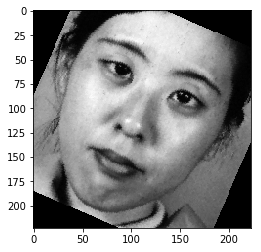

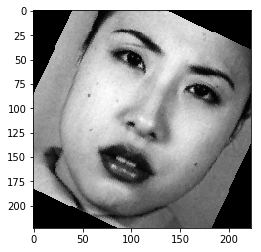

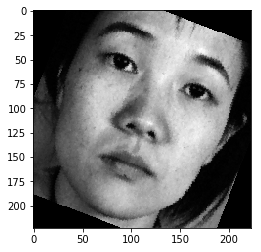

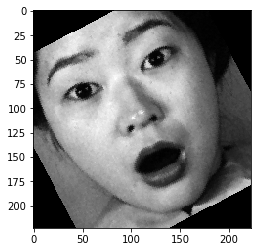

In [12]:
bs, (inputs, targets, boxes, landmarks) = next(itr)
inputs, targets = inputs.numpy(), targets.numpy()
# print(bs)
# print(inputs)
# print(targets)
# print(boxes)
# print(landmarks)
for input in inputs:
    arr = input.reshape([input.shape[1], input.shape[2]])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(arr, cmap="gray")
plt.show()